In [1]:
import torch
from torch import nn
from torch import optim
from torch.functional import F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

/Users/aronsajanphilip/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class WindowSizingDataset(Dataset):
    def __init__(self, dataset:pd.DataFrame):
        self.dataset = dataset
    
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        input_data = torch.Tensor(self.dataset.iloc[index]['T1':'T4'].values.astype('float32'))
        output_data = self.dataset.iloc[index]['Window Size'].astype('float32')
        return input_data, output_data
    
train_dataset = WindowSizingDataset(pd.read_csv("./TrainingData.csv"))
test_dataset = WindowSizingDataset(pd.read_csv("./TestData.csv"))

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)


In [3]:
for training_input, target_output in train_data_loader:
    print(training_input)
    

tensor([[6500.,  300., 6500.,  300.],
        [3200., 3200., 3200., 3200.],
        [5500., 5300., 5300., 5000.],
        [5000.,  400., 5000.,  400.],
        [7500., 8000., 8000., 7500.]])
tensor([[4500., 4500., 4500., 4300.],
        [6500., 7000., 7000., 6500.],
        [8000., 8000., 8000., 8000.],
        [7500., 7700., 7000., 7200.],
        [6500., 7000., 7000., 7000.]])
tensor([[3200.,  100., 3200.,  100.],
        [6500., 6000., 6000., 6300.],
        [2700., 2700., 2700., 3200.],
        [5300.,  200., 5300.,  200.],
        [3000., 3000., 3000., 2700.]])
tensor([[4500., 5000., 5000., 6000.],
        [3000., 3000., 3000., 3000.]])


In [4]:
device = torch.device("cpu")    
class BufferPredictionNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features=4, out_features=3, device=device)
        self.fc2 = nn.Linear(in_features=3, out_features=1, device=device)
    
    def forward(self, input_wt):
        x = F.relu(self.fc1(input_wt))
        x = self.fc2(x)
        return x.cpu()
     

In [41]:

net = BufferPredictionNetwork()
optimizer = optim.Adam(params=net.parameters(), lr=0.0003)
criterion = nn.MSELoss()

In [42]:

LOG_INTERVAL = 1000
net.train()
for epoch in range(0,7001):
    for training_input, target_output in train_data_loader:
        optimizer.zero_grad()
        prediction = net(training_input.to(device=device))
        loss = criterion(prediction.squeeze().to(device), target_output.to(device=device))
        loss.backward()
        optimizer.step()
    if(epoch%LOG_INTERVAL == 0):
        print("Epoch {}; Loss {}".format(epoch,loss.item()))

Epoch 0; Loss 79177472.0
Epoch 1000; Loss 433802.96875
Epoch 2000; Loss 38564.85546875
Epoch 3000; Loss 1286.470703125
Epoch 4000; Loss 773679.0
Epoch 5000; Loss 4290.61181640625
Epoch 6000; Loss 31368.12109375
Epoch 7000; Loss 65589.171875


In [46]:
torch.save(net.state_dict(), './window_size_model.pt')

In [47]:
net.load_state_dict(torch.load("./window_size_model.pt"))

<All keys matched successfully>

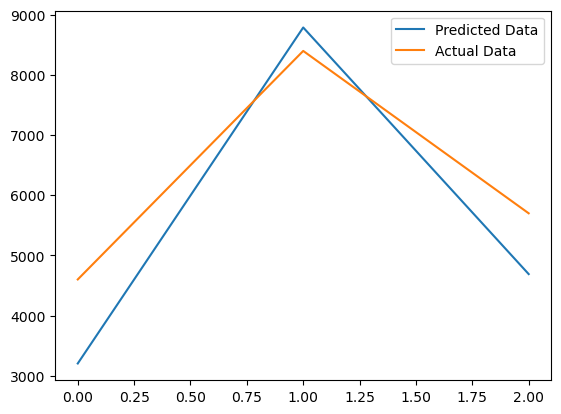

In [50]:
net.eval()

in_data, out_data = iter(test_data_loader).next()

out = net(in_data.to(device))

plt.plot(range(0,len(out_data)), out.detach().numpy().squeeze(), label="Predicted Data")
plt.plot(range(0,len(out_data)), out_data.numpy(),  label='Actual Data')
plt.legend()

In [ ]:
#torch.save(net.state_dict(), './window_size_model.pt')